author = "Vrushali Dipak Fangal" <br>
copyright = "Copyright 2014" <br>
license = "MIT" <br>
maintainer = "Vrushali Dipak Fangal" <br>
email = "vrushali.fangal@channing.harvard.edu" <br>

#### <div class="alert-warning"> <u>This notebook generates Figure 6, Figure S9, Figure S10, Figure S11 </u></div> 

# &#9635; Costa Rica Cohort of Childhood Patients

In [1]:
## Import Python Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import scipy.stats as stats
from scipy.stats import kde
import matplotlib as mpl
import statsmodels
from sklearn import metrics
from statsmodels.stats.multitest import multipletests
import natsort
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#### <u> <font color=blue>Preprocessing</font>  </u>

Expression data were then log2-transformed and quantile-normalized using the *lumiT* and *lumiN* functions, respectively, from the R package *lumi*.

we applied a standard non-specific variance filter to the expression data using the *nsFilter* function from the R package *genefilter* (version 1.48). We removed probes not annotated with a valid Entrez gene identifier or Human Genome Organisation (HUGO) gene symbol and probes with inter-quartile ranges (IQR) of expression variance below the 50th percentile, ensuring that the most informative probes were used for analysis. We then collapsed the data to a single probe per gene based on the largest IQR of expression variance.



***
#### <u> <font color=blue>Load Gene Expression Data</font>  </u>

In [2]:
df = pd.read_csv('../Data/CR_transcriptomics_data.csv').set_index('Subject_ID')
patient_params = df[[ 'age', 'gender', 'Gender_in_numeric', 'htcm',
       'Weight_in_kg', 'BMI', 'treatment', 'sa_pd20', 'fev1_pred',
       'fev1_fvc_bd0', 'fev1_fvc_bd1', 'bdrbase', 'log10Ige']]


df = pd.read_csv('../Data/CR_transcriptomics_data.csv').set_index('Subject_ID')

## This file is not required for analysis
df_probes = pd.read_csv('../Data/CR_transcriptomics_probes.csv')
df_probes = df_probes[['Unnamed: 0',  'TargetID']]##'ILMN_Gene',
df_probes = df_probes.rename({'Unnamed: 0':'index'}, axis=1).set_index(['index'])
df_probes.shape, df.shape

## drop first 14 columns
df.drop(['Unnamed: 0', 'age', 'gender', 'Gender_in_numeric', 'htcm',
       'Weight_in_kg', 'BMI', 'treatment', 'sa_pd20', 'fev1_pred',
       'fev1_fvc_bd0', 'fev1_fvc_bd1', 'bdrbase', 'log10Ige',], axis=1, inplace=True)

df = df.T

df_transcriptomics = df.merge(df_probes, how='inner', left_index=True, right_index=True).set_index('TargetID')
df_transcriptomics.to_csv('transcriptomics.tsv',sep='\t') 
genes = list(df_transcriptomics.index.values)
df_transcriptomics.shape, df.shape, df_probes.shape
patients = list(df_transcriptomics.columns)

## Remove duplicate genes
df_transcriptomics = df_transcriptomics.loc[~df_transcriptomics.index.duplicated(keep='first')]

print('Total Genes: ',df_transcriptomics.shape[0])


Total Genes:  25058


#### <u> <font color=blue> Phenotype data of patients </font>  </u>

In [3]:
df_pheno = pd.read_csv('../Data/COS_TRIO_pheno_1165.csv').set_index('IID')

df_pheno = df_pheno[df_pheno.index.isin(patients)]
df_pheno= df_pheno[df_pheno['Persistent_asthma']==2]
df_pheno.to_csv('meta.tsv',sep='\t')
print('Total Patients: ', df_pheno.shape[0])

drugs = ['SA_Inhaled_B2_agonists', 'SA_Oral_B2_agonists','LA_Inhaled_B2_agonists','SA_Inhaled_Anticholinergics',
         'Inhaled_Steroids','Oral_Steroids', ## steroids
         'Leukotriene_Inhibitors', ## Leukotriene inhibitor
         'Xanthines',  ## broncodilators
         'Chromolyn_Intal', ## Mast cell stabilizer
         'Anti_inflammatory_Med']


symptoms = ['Asthma_Wheeze_AHR_BDR', 
            'AHR_Symptoms',
            'Cough_Chronic_Bronchitis',
            'G15D', #Doctor told about chronic bronchitis
            'G12G', ## Wheezing made shortness of breath
            'Asthma_Wheeze',
            'Wheeze_composite',
            'cough_composite',
           'G14E' ,##Chest tightness
            'G14', ##Ever been trouble by shortness of breath: 2 for Yes, 1 for No 
            'G10H' #Coughs on most days of the week
           ]



Total Patients:  321


In [4]:
#df_transcriptomics = 2**df_transcriptomics[df_pheno.index]
df_transcriptomics.to_csv('transcriptomics.tsv',sep='\t') 

***
## <u> <font color=hotpink> K-Means Clustering </font>  </u>

In [5]:
from sklearn.cluster import KMeans

num_grp = 3
kmeans = KMeans(n_clusters=num_grp,random_state=42)
data= df_transcriptomics.T.loc[df_pheno.index]
kmeans.fit(data)
pred = kmeans.predict(data)
frame = pd.DataFrame(data)
frame['cluster'] = pred

### Save files
neu_low_patient = df_pheno
df_pheno['neu'] =  ''

num_grp = len(set(frame['cluster']))

#Cluster 0 (Th1 + Th17)
neu_high_patients = frame[frame['cluster']==0].index.values
df_pheno.loc[neu_high_patients, 'neu'] = 'Cluster '+str(2)

#Cluster 1 (Th1)
neu_high_patients = frame[frame['cluster']==1].index.values
df_pheno.loc[neu_high_patients, 'neu'] = 'Cluster '+str(1)

#Cluster 2 (Th1 + Th2 + Th17)
neu_high_patients = frame[frame['cluster']==2].index.values
df_pheno.loc[neu_high_patients, 'neu'] = 'Cluster '+str(3)

df_pheno[df_pheno['neu'].notna()].to_csv('neu_meta.tsv', sep='\t')

for i in range(3):
    print('Group '+str(i)+':',frame[frame['cluster']==i].shape[0])
    
print('Group 1 --> Cluster 1 (Th1)')
print('Group 0 --> Cluster 2 (Th1 + Th17)')
print('Group 2 --> Cluster 3 (Th1 + Th2 + Th17)')


Group 0: 84
Group 1: 112
Group 2: 125
Group 1 --> Cluster 1 (Th1)
Group 0 --> Cluster 2 (Th1 + Th17)
Group 2 --> Cluster 3 (Th1 + Th2 + Th17)


***
## Clinical correlates per cluster

In [6]:
cols = ['age','BMI']+['EOSIN_C','tot_ige','fev1_fvc_bd0','fev1_fvc_bd1','bdrbase','log10sa_pd20']+drugs+symptoms + ['gender']

patient_charac = []

for col in cols:
    lst = [col]
    for name, grp in df_pheno.groupby('neu'):
        grp[col] = grp[col].dropna()
        if len(grp[col].unique()) > 3:
            lst.append(np.round(grp[col].mean(),2))
        else:
            if 2 in grp[col].dropna().unique():
                lst.append(grp[col].value_counts()[2])
            else:
                print(name,'\n', grp[col].value_counts())
    patient_charac.append(lst)
    
patient_charac = pd.DataFrame(patient_charac)
patient_charac.columns = ['Patient Characteristics', 'Cluster 1', 'Cluster 2', 'Cluster 3']
patient_charac.to_csv('Pat_Char.tsv', sep='\t', index=None)

Cluster 1 
 M    71
F    41
Name: gender, dtype: int64
Cluster 2 
 M    43
F    41
Name: gender, dtype: int64
Cluster 3 
 M    74
F    51
Name: gender, dtype: int64


***
***

> #### <u> <font color=red> Fig. 6a </font>  </u>

#### <u> <font color=blue>PCA of Clusters</font>  </u>

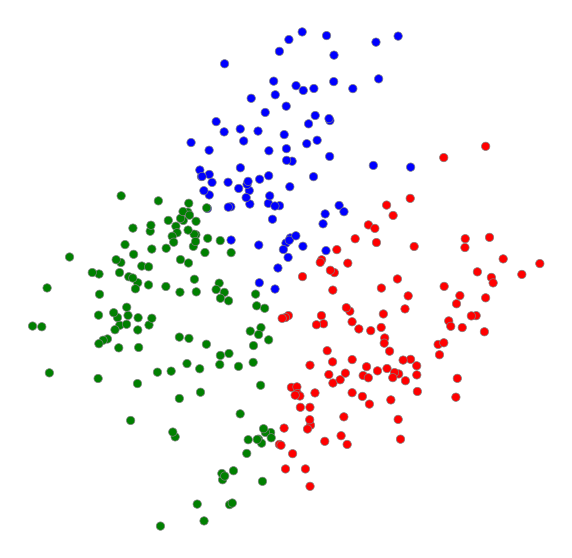

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data)
PCA_components = pd.DataFrame(principalComponents)
df = pd.DataFrame()
df['PC0'] = PCA_components[0]
df['PC1'] = PCA_components[1]
df['cluster'] = frame['cluster'].values


plt.figure(figsize=(10,10))
sns.scatterplot(
    x="PC0", y="PC1",
    hue="cluster",
    palette=['b','r','g'],
    data=df,
    marker = 'o',
    s=70,
    edgecolor="grey"
)

plt.axis('off')
plt.legend('',frameon=False)
plt.savefig("kmeans.pdf", bbox_inches='tight')
plt.savefig("kmeans.svg", bbox_inches='tight')


***
## <u> <font color=hotpink> Differential Expression </font>  </u>

#### <u> <font color=blue> Genes of Interest </font>  </u>
Genes of interest include interleukins, CD markers, chemokines, and transcription factors T cells in asthma gene network.

In [8]:
genes_of_interest = [gene for gene in genes if gene.startswith('IL') and gene[2].isdigit()]  + \
[gene for gene in genes if gene.startswith('CXC')] + \
[gene for gene in genes if gene.startswith('CCR')] + \
[gene for gene in genes if gene.startswith('STAT') and gene[4].isdigit()] + \
[gene for gene in genes if gene.startswith('RUNX')] + \
['GATA1','GATA2','GATA3'] + \
[gene for gene in genes if gene.startswith('FCER')] + \
[gene for gene in genes if gene.startswith('GZM')] + \
[gene for gene in genes if gene.startswith('HRH')] + \
[gene for gene in genes if gene.startswith('TGF')] + \
[gene for gene in genes if gene.startswith('CSF')] + \
['IFNAR2', 'IFNGR1', 'IFNGR2', 'IFNAR1', 'IFNG']

# [gene for gene in genes if gene.startswith('CCL')] + \
#[gene for gene in genes if len(gene)>4 and gene.startswith('IFN') and gene[3].isalpha() and (gene[4]=='R')]

genes_of_interest.extend(['GATA3','STAT6',## Th2 transcription factors
                      'FCER2','FCER1A', 'FCER1G',## IgE related
                          'TFE3', ## Mast Cells
                      'CCR6', 'CCR4', 'RORA', 'STAT3', 'RORC', ## Th17 transcription factors
                      'TBX21', 'STAT1', 'STAT4', 'LTA', ## Th1 transcription factors and variants of IFN
                      'FOXP3', ## T-reg transcription factors
                      'CD19','RUNX1', 'IKZF1', 'EBF1', 'TCF3','PAX5', ## B cells
                      'CLC','CCR3','ITGAM','ANPEP', 'CR1', 'CD44', 'EMR1' ,'CD81', 'PRG2','SIGLEC8', 'RNASE3', 'RNASE2','EPX', ##Eosinophil , ITGAM=CD11B, CD35=CR1, 'CD193'= CCR3, 'CD66',
                      'CXCR3', 'LY6G6D' ,'CD33', ## Neutrophils
                     'FUT4', 'FCGR3A','FCGR3B',# Neutrophils	CD15, CD16
                     'LAMP1', 'LAMP3','ITGA2', ##Basophils
                        #### Basophils
                      'PI4K2A','KARS','ENPP3',  ###### Basophils
                      'CCR3', 'CD22',  'KIT', ###### Basophils
                      'GPR44', 'IL3RA',  'CEBPA', ###### Basophils
                          
                     'TNF', 'CD4', 'CD8A','CD8B', ## CD markers
                     'ARG1', 'ARG2', ## Macrophages
                        'IRF5', 'IRF8',  ## M1
                          'IRF2', 'IRF3', ##M2
                    'CDH1', 'EPCAM','CXCL5', ## Epithelial
                    'CYSLTR1', 'CYSLTR2', ## cysteinyl-leukotriene , HRH is hitamines
                        
                    ])


genes_of_interest = list(natsort.natsorted(set(genes_of_interest)))



print('Genes of Interest: ')
print(*genes_of_interest, sep = ", " )
print('Number of Genes: ',len(genes_of_interest))


set(genes_of_interest) - set(df_transcriptomics.index)


Genes of Interest: 
ANPEP, ARG1, ARG2, CCR1, CCR2, CCR3, CCR4, CCR6, CCR7, CCR8, CCR9, CCR10, CCRK, CCRL1, CCRL2, CCRN4L, CD4, CD8A, CD8B, CD19, CD22, CD33, CD44, CD81, CDH1, CEBPA, CLC, CR1, CSF1, CSF1R, CSF2, CSF2RB, CSF3, CSF3R, CXCL1, CXCL2, CXCL3, CXCL5, CXCL6, CXCL9, CXCL10, CXCL11, CXCL12, CXCL13, CXCL14, CXCL16, CXCL17, CXCR1, CXCR3, CXCR4, CXCR5, CXCR6, CXCR7, CYSLTR1, CYSLTR2, EBF1, EMR1, ENPP3, EPCAM, EPX, FCER1A, FCER1G, FCER2, FCGR3A, FCGR3B, FOXP3, FUT4, GATA1, GATA2, GATA3, GPR44, GZMA, GZMB, GZMH, GZMK, GZMM, HRH1, HRH2, HRH3, HRH4, IFNAR1, IFNAR2, IFNG, IFNGR1, IFNGR2, IKZF1, IL1A, IL1B, IL1F5, IL1F6, IL1F7, IL1F8, IL1F9, IL1F10, IL1R1, IL1R2, IL1RAP, IL1RAPL1, IL1RAPL2, IL1RL1, IL1RL2, IL1RN, IL2, IL2RA, IL2RB, IL2RG, IL3, IL3RA, IL4, IL4I1, IL4R, IL5, IL5RA, IL6, IL6R, IL6ST, IL7, IL7R, IL8, IL8RB, IL8RBP, IL9, IL9R, IL10, IL10RA, IL10RB, IL11, IL11RA, IL12A, IL12B, IL12RB1, IL12RB2, IL13, IL13RA1, IL13RA2, IL15, IL15RA, IL16, IL17A, IL17B, IL17C, IL17D, IL17F, IL17R

set()

In [9]:
'Surface Markers:', len(set([gene for gene in genes_of_interest if gene.startswith('CD')] +[gene for gene in genes_of_interest if gene.startswith('CCR')] + \
[gene for gene in genes_of_interest if gene.startswith('CXC')] + [gene for gene in genes_of_interest if gene.startswith('CCL')]))

('Surface Markers:', 41)

In [10]:
223-41

182

***
## <u> <font color=hotpink> Functions </font>  </u>

*`DE Boxplots`*

In [11]:
meanlineprops = dict(linestyle='--', linewidth=2.5, color='cyan')
meanpointprops = dict(marker='.', markeredgecolor='black',
                      markerfacecolor='yellow')
whiskerprops = dict(linestyle=':', color='black')

def draw_plot(data, edge_color, fill_color, position):
    
    bp = plt.boxplot(data, patch_artist=True,showfliers=False, 
                     positions=position, widths = 0.75,    
                     meanprops=meanpointprops,
                      whiskerprops = whiskerprops, 
                     showmeans=True)#,  widths=4) 
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
def DE_Boxplot(group, up_group, color, title, fname, size, font_size, factor):
    
    up = up_group
    
    low = frame[frame['cluster']!=group]
    low = df_transcriptomics.loc[up,low.index].T

    high = frame[frame['cluster']==group]
    high = df_transcriptomics.loc[up,high.index].T
    n = low.shape[1]

    plt.figure(figsize = size)    
    draw_plot(low.T, 'black', 'grey', position=np.arange(0,n*2,2))
    draw_plot(high.T, 'black', color, position=np.arange(0,n*2,2)+1)

    plt.xticks(np.arange(0,n*2,2)+0.5, low.columns, rotation=90, fontsize=font_size) 
    plt.yticks(fontsize=font_size)
    plt.title(title, fontsize = font_size *1.4, fontweight='bold')

    for x in np.arange(0,n*2,2)-0.5:
        plt.axvline(x, c='lightgrey', linestyle='dashed', linewidth=0.25)
        
    plt.xlabel('Genes', fontsize = font_size*factor)
    plt.ylabel('$log_2($Normalized Expression$)$', fontsize = font_size*factor)

    plt.savefig(fname, bbox_inches='tight')



*`Word Cloud`*

In [12]:
def tf_red_func(df_grp):
    def red_func(word=None, font_size=None, 
                       position=None, orientation=None, 
                       font_path=None, random_state=2):
        h = int(1000* df_grp[df_grp['name']==word]['log2fc'].values)
        s = int(20* df_grp[df_grp['name']==word]['log2fc'].values)
        l = int(20* df_grp[df_grp['name']==word]['log2fc'].values)
        return "rgb({}%, {}%, {}%)".format(h, s ,l)#"rgb(0%%, 255%% * %d, 0%%)" % (360 * df_grp[df_grp['name']==word]['log2fc'])
    return red_func

def tf_green_func(df_grp):
    def green_func(word=None, font_size=None, 
                       position=None, orientation=None, 
                       font_path=None, random_state=2):
        h = int(400* df_grp[df_grp['name']==word]['log2fc'].values)
        s = int(600* df_grp[df_grp['name']==word]['log2fc'].values)
        l = int(400* df_grp[df_grp['name']==word]['log2fc'].values)
        #print(h,s,l)
        return "rgb({}%, {}%, {}%)".format(h, s ,l)
    return green_func

def tf_blue_func(df_grp):
    def blue_func(word=None, font_size=None, 
                       position=None, orientation=None, 
                       font_path=None, random_state=2):
        h = int(200* df_grp[df_grp['name']==word]['log2fc'].values)
        s = int(200* df_grp[df_grp['name']==word]['log2fc'].values)
        l = int(1000* df_grp[df_grp['name']==word]['log2fc'].values)
        #print(h,s,l)
        return "rgb({}%, {}%, {}%)".format(h, s ,l)#"rgb(0%%, 255%% * %d, 0%%)" % (360 * df_grp[df_grp['name']==word]['log2fc'])
    return blue_func



def Cluster_wordcloud(log2fc, up_group, tf_func, fname):

    log2fc = { key: log2fc[key] for key in up_group } 

    df_grp = {'name': list(log2fc.keys()),
               'log2fc': list(log2fc.values())}
    df_grp = pd.DataFrame(df_grp)
    tuples = [tuple(x) for x in df_grp.values]

    wordcloud3 = WordCloud(width=3000, height=2000, margin=0, background_color="white",
                           #min_font_size = 150, 
                           #max_font_size=600,
                           color_func=tf_func(df_grp)).generate_from_frequencies(dict(tuples))
    
    plt.figure()
    
    plt.imshow(wordcloud3)#, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.tight_layout(pad=0)
    plt.savefig(fname, bbox_inches='tight')
    


***
## <u> <font color=hotpink> Box Plot </font>  </u>

#### <u> <font color=blue> CLUSTER 1 - T$_H$1 </font>  </u>

> #### <u> <font color=red> Fig. S9a </font>  </u>

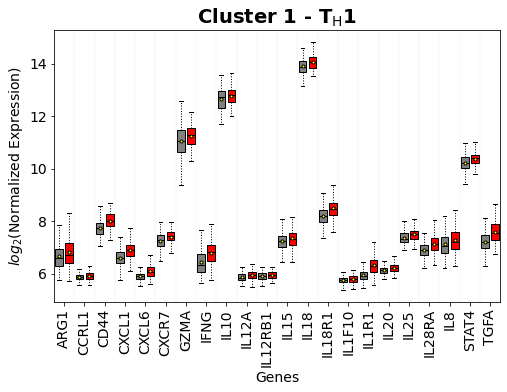

In [13]:
df1 = pd.read_csv('DE_Cluster1.txt', sep='\t', index_col=0)

DE_Boxplot(1 , list(df1.sort_index().index), 'r', 'Cluster 1 - T$_\mathrm{H}$1', 'DE_Cluster1_Th1.pdf', [8,5], 14, 1)




#### <u> <font color=blue> CLUSTER 2 - T$_H$1 + T$_H$17 </font>  </u>

> #### <u> <font color=red> Fig. S9b </font>  </u>

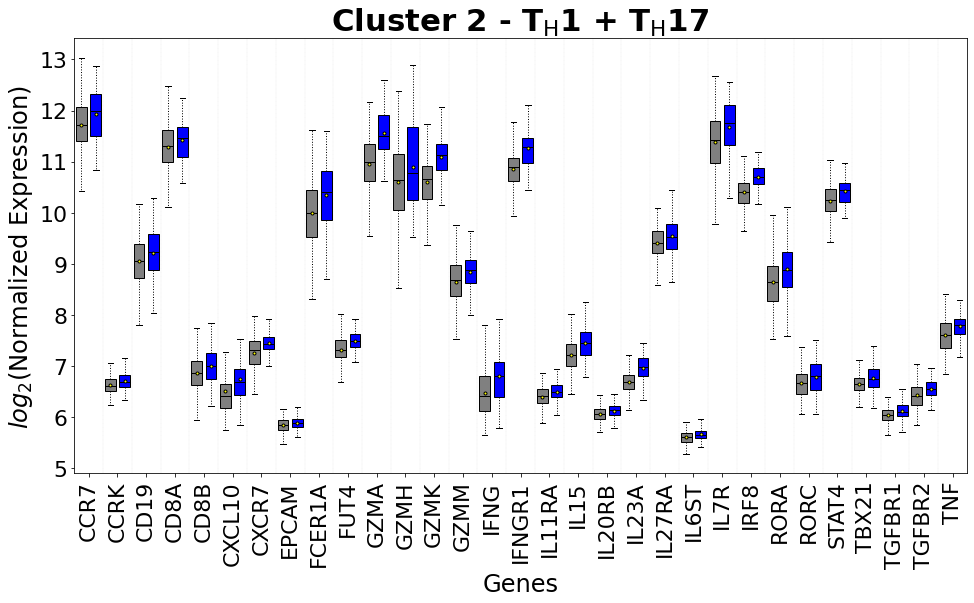

In [14]:
df2 = pd.read_csv('DE_cluster2.txt', sep='\t', index_col=0)
DE_Boxplot(0 , list(df2.sort_index().index), 'b', 'Cluster 2 - T$_\mathrm{H}$1 + T$_\mathrm{H}$17', 'DE_Cluster2_Th1_Th17.pdf', [16,8], 22, 1.1)





#### <u> <font color=blue> CLUSTER 3 - T$_H$1 + T$_H$17 + T$_H$1 </font>  </u>

> #### <u> <font color=red> Fig. S9c </font>  </u>

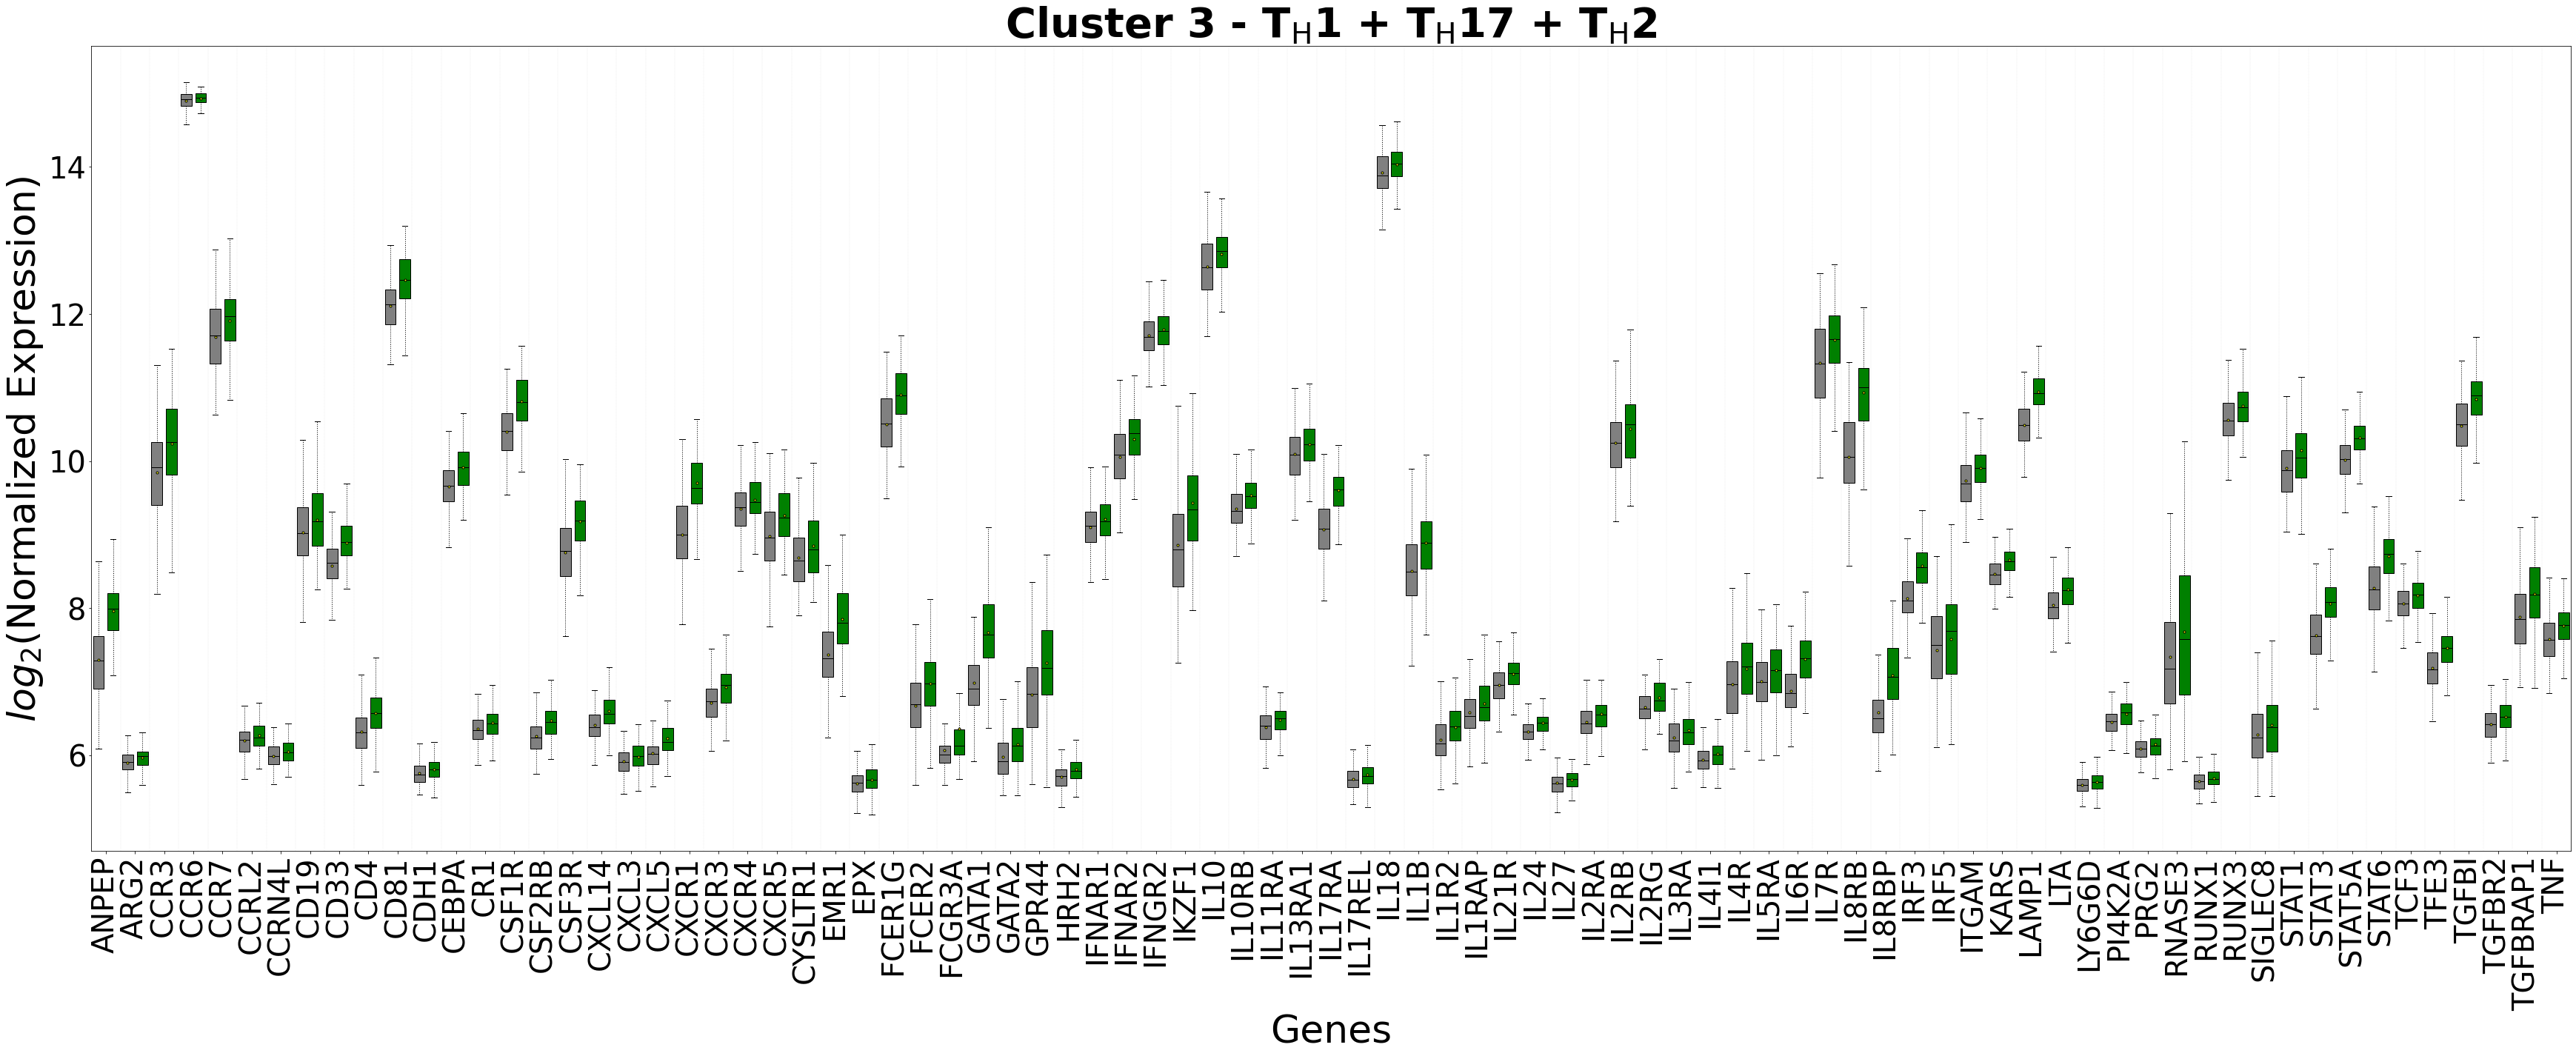

In [15]:
df3 = pd.read_csv('DE_cluster3.txt', sep='\t', index_col = 0)
DE_Boxplot(2 , list(df3.sort_index().index), 'g', 'Cluster 3 - T$_\mathrm{H}$1 + T$_\mathrm{H}$17 + T$_\mathrm{H}$2', 'DE_Cluster3_Th1_Th17_Th2.pdf', [60,20], 40, 1.3)




***
## <u> <font color=hotpink> Word Cloud </font>  </u>

> #### <u> <font color=red> Fig. 6a </font>  </u>

#### <u> <font color=blue> CLUSTER 1 - T$_H$1 </font>  </u>

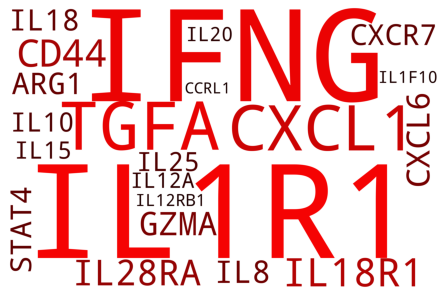

In [16]:
df1 = pd.read_csv('DE_cluster1.txt',sep ='\t', index_col=0)
Cluster_wordcloud(df1.logFC/4, df1.index, tf_red_func, 'wc_cluster1.pdf')


#### <u> <font color=blue> CLUSTER 2 T$_H$1 + T$_H$17 </font>  </u>

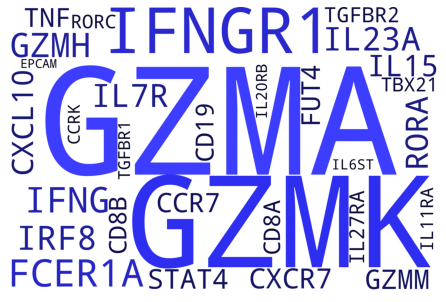

In [17]:
df2 = pd.read_csv('DE_cluster2.txt',sep ='\t', index_col = 0)
Cluster_wordcloud(df2.logFC/5, df2.index, tf_blue_func, 'wc_cluster2.pdf')


#### <u> <font color=blue> CLUSTER 3  T$_H$1 + T$_H$17 + T$_H$2</font>  </u>

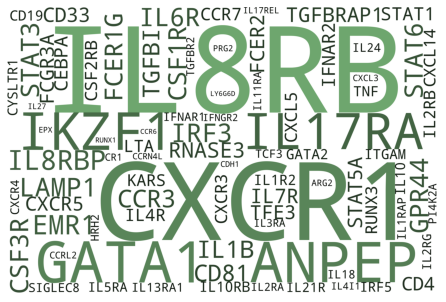

In [18]:

df3 = pd.read_csv('DE_cluster3.txt',sep ='\t', index_col =0)
Cluster_wordcloud(df3.logFC/8, df3.index, tf_green_func, 'wc_cluster3.pdf')

***
## <u> <font color=hotpink> Clinical Correlates </font>  </u>

> #### <u> <font color=red> Fig. 6b </font>  </u>

In [19]:
## Violin Plot
clusters = ['Cluster 1', 'Cluster 2', 'Cluster 3']
sns.set_style('ticks', {'font.sans-serif': 'Arial'})


<Figure size 432x288 with 0 Axes>

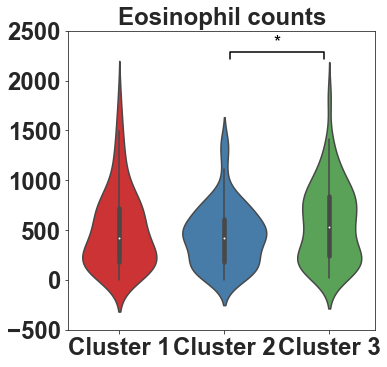

In [20]:
plt.figure()
fig, ax = plt.subplots(nrows=1,  figsize=(5.5,5.5)) 
sns.violinplot( y='EOSIN_C', x = 'neu',data = df_pheno, order=clusters, palette='Set1',edgecolor='black', ax= ax)
plt.title('Eosinophil counts', fontsize='24', fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.ylim([-500,2500])
plt.xticks(fontsize=24, fontweight='bold')
plt.yticks(fontsize=24, fontweight ='bold')
clusters = ['Cluster 1', 'Cluster 2', 'Cluster 3']
param = 'EOSIN_C'
for i in range(2):
        pval = stats.ranksums(df_pheno[df_pheno['neu']==clusters[i]][param], df_pheno[df_pheno['neu']==clusters[i+1]][param])
        x1, x2 = i+0.05, i+1-0.05 
        y, h, col = df_pheno[param].mean() + 1700 , 70, 'k'
        if (pval.pvalue < 0.0005):
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*.5, y+h,"***", ha='center', va='bottom', color=col, fontsize=18)
        elif (pval.pvalue < 0.005):
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*.5, y+h,"**", ha='center', va='bottom', color=col, fontsize=18)
        elif (pval.pvalue < 0.05):
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*.5, y+h,"*", ha='center', va='bottom', color=col, fontsize=18)
plt.savefig('6b.pdf',bbox_inches='tight')
plt.savefig('6b.svg',bbox_inches='tight')



> #### <u> <font color=red> Fig. 6c </font>  </u>

<Figure size 432x288 with 0 Axes>

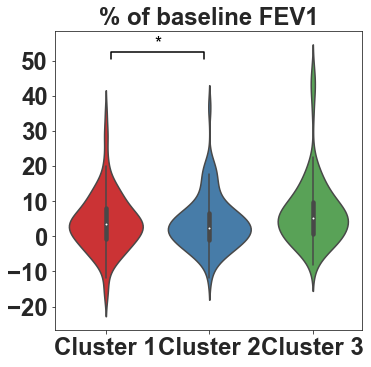

In [21]:
plt.figure()
fig, ax = plt.subplots(nrows=1,  figsize=(5.5,5.5)) 
sns.violinplot( y='bdrbase', x = 'neu',data = df_pheno, order=clusters, split=True, palette='Set1',edgecolor='grey', ax = ax)
plt.title('% of baseline FEV1', fontsize=24, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=24, fontweight='bold')
plt.yticks(fontsize=24, fontweight='bold')
param = ['log10sa_pd20']
for i in range(2):
        pval = stats.ranksums(df_pheno[df_pheno['neu']==clusters[i]][param], df_pheno[df_pheno['neu']==clusters[i+1]][param])
        x1, x2 = i+0.05, i+1-0.05 
        y, h, col = df_pheno[param].mean() + 50 , 2, 'k'
        if (pval.pvalue < 0.0005):
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*.5, y+h,"***", ha='center', va='bottom', color=col, fontsize=18)
        elif (pval.pvalue < 0.005):
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*.5, y+h,"**", ha='center', va='bottom', color=col, fontsize=18)
        elif (pval.pvalue < 0.05):
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*.5, y+h,"*", ha='center', va='bottom', color=col, fontsize=18)
plt.savefig('6c.pdf',bbox_inches='tight')
plt.savefig('6c.svg',bbox_inches='tight')

> #### <u> <font color=red> Fig. 6d </font>  </u>

<Figure size 432x288 with 0 Axes>

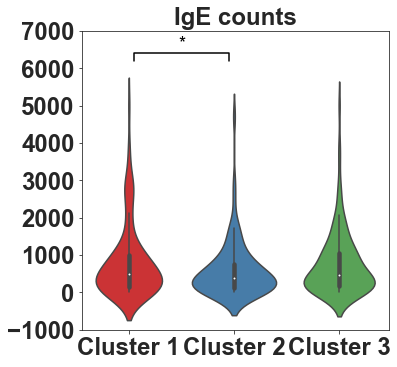

In [22]:
plt.figure()
fig, ax = plt.subplots(nrows=1,  figsize=(5.5, 5.5)) 
sns.violinplot( y='tot_ige', x = 'neu',data = df_pheno, order=clusters, split=True, palette='Set1',edgecolor='grey', ax= ax)
plt.title('IgE counts', fontsize=24, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.ylim([-1000, 7000])
plt.xticks(fontsize=24, fontweight='bold')
plt.yticks(fontsize=24, fontweight='bold')
param = ['log10sa_pd20']
for i in range(2):
        pval = stats.ranksums(df_pheno[df_pheno['neu']==clusters[i]][param], df_pheno[df_pheno['neu']==clusters[i+1]][param])
        x1, x2 = i+0.05, i+1-0.05 
        y, h, col = df_pheno[param].mean() + 6200 , 200, 'k'
        if (pval.pvalue < 0.0005):
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*.5, y+h,"***", ha='center', va='bottom', color=col, fontsize=18)
        elif (pval.pvalue < 0.005):
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*.5, y+h,"**", ha='center', va='bottom', color=col, fontsize=18)
        elif (pval.pvalue < 0.05):
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*.5, y+h,"*", ha='center', va='bottom', color=col, fontsize=18)
plt.savefig('6d.pdf',bbox_inches='tight')
plt.savefig('6d.svg',bbox_inches='tight')


> #### <u> <font color=red> Fig. 6e </font>  </u>

<Figure size 432x288 with 0 Axes>

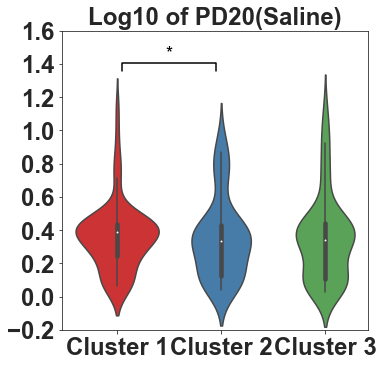

In [23]:
plt.figure()
fig, ax = plt.subplots(nrows=1,  figsize=(5.5,5.5)) 
sns.violinplot( y='log10sa_pd20', x = 'neu',data = df_pheno, order=clusters, palette='Set1',edgecolor='grey', ax= ax)
plt.title('Log10 of PD20(Saline)', fontsize=24, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.ylim([-0.2, 1.6])
plt.xticks(fontsize=24, fontweight='bold')
plt.yticks(fontsize=24, fontweight='bold')
param = ['log10sa_pd20']
for i in range(2):
        pval = stats.ranksums(df_pheno[df_pheno['neu']==clusters[i]][param], df_pheno[df_pheno['neu']==clusters[i+1]][param])
        x1, x2 = i+0.05, i+1-0.05 
        y, h, col = df_pheno[param].mean() + 1. , 0.05, 'k'
        if (pval.pvalue < 0.0005):
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*.5, y+h,"***", ha='center', va='bottom', color=col, fontsize=18)
        elif (pval.pvalue < 0.005):
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*.5, y+h,"**", ha='center', va='bottom', color=col, fontsize=18)
        elif (pval.pvalue < 0.05):
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*.5, y+h,"*", ha='center', va='bottom', color=col, fontsize=18)
plt.savefig('6e.pdf',bbox_inches='tight')
plt.savefig('6e.svg',bbox_inches='tight')

***
## <u> <font color=hotpink> Decision Tree </font>  </u>

> #### <u> <font color=red> Fig. S10a </font>  </u>

DecisionTreeClassifier(criterion='entropy', max_features=2, random_state=42)


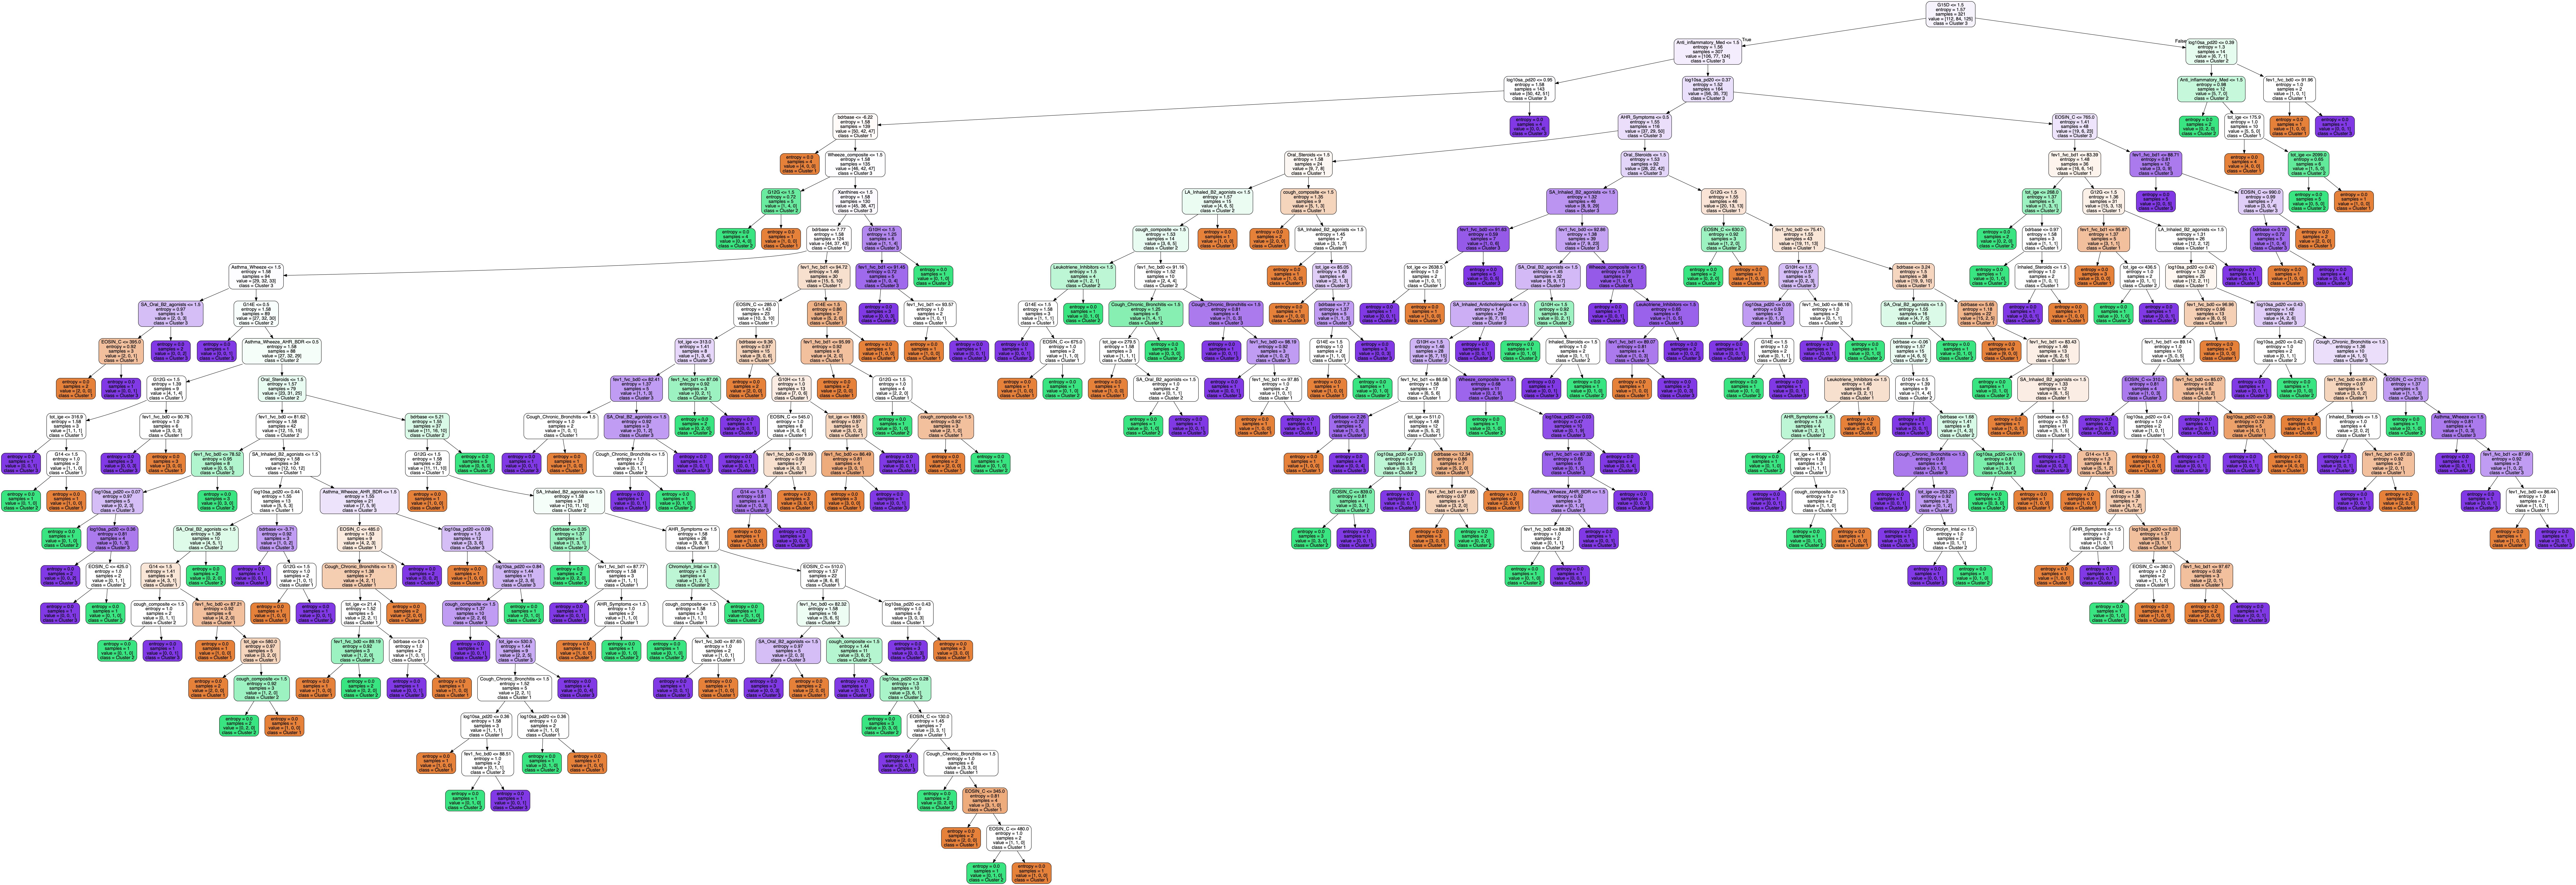

In [24]:
## Clinical correlates are not good enough

cols = drugs+symptoms+['EOSIN_C','tot_ige','fev1_fvc_bd0','fev1_fvc_bd1','bdrbase','log10sa_pd20']
train = df_pheno[cols].fillna(0).dropna(axis='columns')
X = train[cols]
y = df_pheno['neu'].replace({"Cluster 1": 1, 'Cluster 2':2, 'Cluster 3':3})

import pandas as pd
from sklearn.ensemble.forest import DecisionTreeClassifier
from sklearn import tree
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

clf=DecisionTreeClassifier(criterion='entropy',random_state=1)

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [10, None],
              "max_features": range(1, 11),
              "min_samples_leaf": range(1, 11),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree_class = DecisionTreeClassifier(random_state=42)

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = GridSearchCV(tree_class, param_dist, cv=10)

# Fit it to the data
tree_cv.fit(X,y)

print(tree_cv.best_estimator_)

from sklearn.tree import export_graphviz
# Export as dot file
tree.export_graphviz(tree_cv.best_estimator_, out_file='tree.dot',#out_file=None,# 
                feature_names = cols,
                class_names = ['Cluster 1','Cluster 2', 'Cluster 3'],
               rounded = True, proportion = False,
                precision = 2, filled = True)


# Convert to png using system command (requires Graphviz)
from subprocess import call
#call(['dot', '-Tpng', 'tree.dot', '-o', 'Decision_Tree.png', '-Gdpi=100'])
call(['dot', '-Tpng', 'tree.dot', '-o', 'Decision_Tree.png', '-Gdpi=100'])


# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'Decision_Tree.png', width = 1600, height = 1600)



In [25]:
## Unclassified patients by Decision Tree
set(np.array(tree_cv.best_estimator_.predict(X)-y))

{0}

In [26]:
len(cols)

27

#### <u> <font color=blue> CH Score of Clusters </font>  </u>

> #### <u> <font color=red> Fig. S10b </font>  </u>

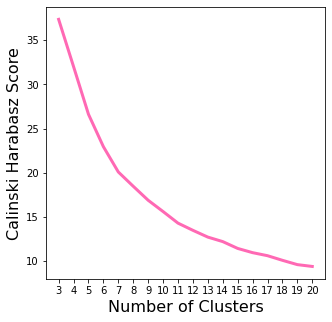

In [27]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

silhouette_coefficients = []
cv_score = []
for k in range(3, 21):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    score = silhouette_score(data, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)
    cv_score.append(calinski_harabasz_score(data, kmeans.labels_))

## CH score
plt.figure(figsize=[5,5])
plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('seaborn')
plt.plot(range(3, 21), cv_score, linewidth=3, color='hotpink')
plt.xticks(range(3, 21))
plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("Calinski Harabasz Score", fontsize=16)
plt.savefig('chose_clusters.pdf', bbox_inches='tight')
plt.style.use('default')

> #### <u> <font color=red> Fig. S10d </font>  </u>

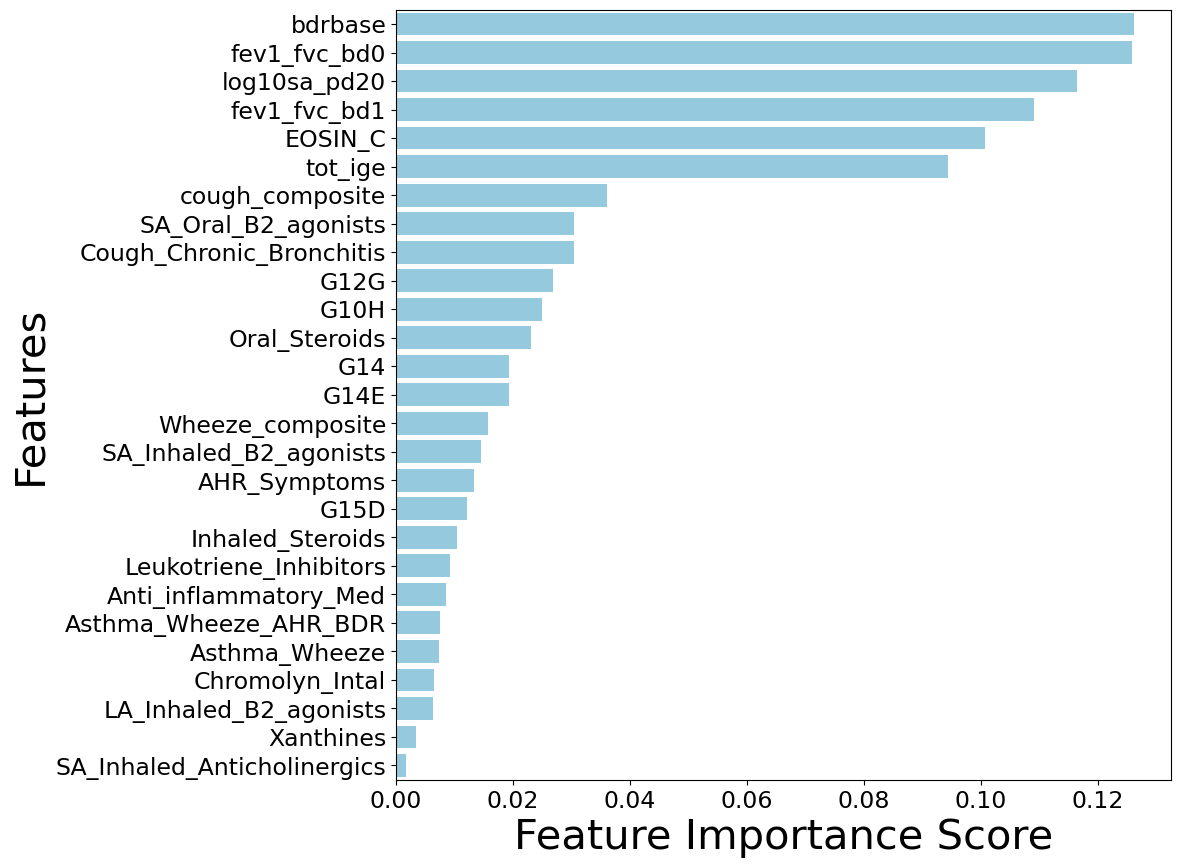

In [28]:
plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('seaborn')

plt.figure(figsize=[10,10])
feature_imp = pd.Series(tree_cv.best_estimator_.feature_importances_,index=X.columns).sort_values(ascending=False)


# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index, color ='skyblue')#hotpink

# Add labels to your graph
plt.xlabel('Feature Importance Score',fontsize=30)
plt.ylabel('Features', fontsize=30)
#plt.title("Feature Ranking", fontsize=20)
plt.tick_params(axis='both', labelsize=17)
plt.savefig('Feature_Importance.pdf', bbox_inches='tight')
plt.style.use('default')

***
## <u> <font color=hotpink> Drug Resistance </font>  </u>

In [29]:
df =  df_pheno#[df_pheno['G22D']>1] #[(df_pheno['Inhaled_Steroids']==2)|  (df_pheno['Oral_Steroids']==2)  ]

for name, grp in df.groupby('neu'):
    print(name, grp.shape[0])
    print('#Hospitalized more than once in the past year: ',grp[grp['G20B']>1].shape[0])#, grp[grp['G20B']>1].shape[0]/grp.shape[0])
    print('#UC more than once in the past year: ',grp[grp['G20D']>1].shape[0])#, grp[grp['G20D']>2].shape[0]/grp.shape[0])
  

Cluster 1 112
#Hospitalized more than once in the past year:  84
#UC more than once in the past year:  78
Cluster 2 84
#Hospitalized more than once in the past year:  65
#UC more than once in the past year:  62
Cluster 3 125
#Hospitalized more than once in the past year:  86
#UC more than once in the past year:  77


> #### <u> <font color=red> Fig. 6f </font>  </u>

Cluster 1
Doctor's office > 1 last year 78.67
Urgent care > 1 last year 78.67
*****************
Cluster 2
Doctor's office > 1 last year 86.54
Urgent care > 1 last year 86.54
*****************
Cluster 3
Doctor's office > 1 last year 81.82
Urgent care > 1 last year 75.32
*****************
   Patients Taking Steroids  Visited ER  Visited Doctor's Office
0                     66.96       52.68                    52.68
1                     61.90       53.57                    53.57
2                     61.60       46.40                    50.40


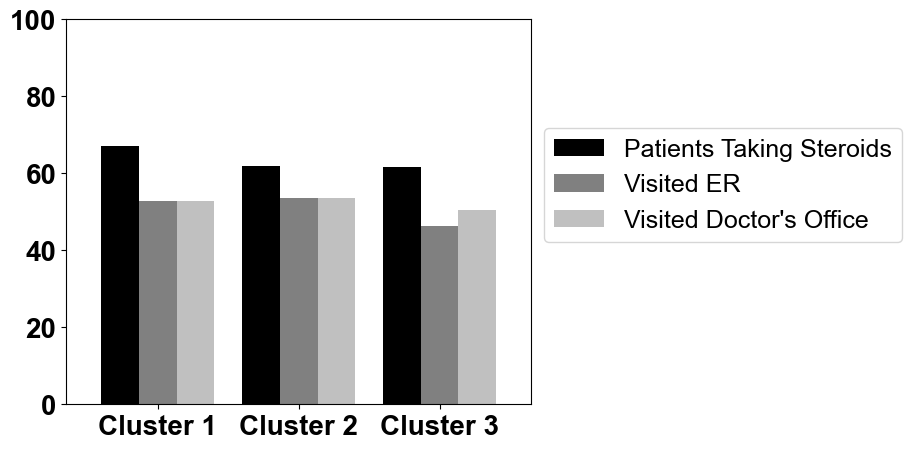

In [30]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
def autolabel(ax):
    for p in ax.patches:
        b = p.get_bbox()
        val = "{:.2f}".format(b.y1 + b.y0)+'%'     
        ax.annotate(val, ((b.x0 + b.x1)/2-0.18 , 1.2*b.y1 ), fontsize=10)

df = df_pheno[ ((df_pheno['Oral_Steroids']==2)| (df_pheno['Inhaled_Steroids']==2)) &  (df_pheno['G22D']>1) ]

# G20B --> Number of time visited a doctor for asthma in last 12 months
# G20D --> Number of times Urgent care visit for asthma in last 12 months

df_bar = pd.DataFrame()
steroids = []
any_er_visits = []
any_dr_visits = []
urgent_care = []
doc_last_yr = []
for name, grp in df.groupby('neu'):
    print(name)
    total = df_pheno[df_pheno.neu==name].shape[0]
    steroids.append( np.round(grp.shape[0]*100/total,2))
    doc_last_yr.append(np.round(grp[grp['G20B']>1].shape[0]*100/total,2))
    urgent_care.append(np.round(grp[grp['G20D']>1].shape[0]*100/total, 2))
    print('Doctor\'s office > 1 last year', np.round(grp[grp['G20B']>1].shape[0]*100/grp.shape[0],2)) ## Doctor more than once
    print('Urgent care > 1 last year', np.round(grp[grp['G20D']>1].shape[0]*100/grp.shape[0], 2)) ## Urgent Care more than once
    print('*****************')

df_bar['Patients Taking Inhaled Steroids'] = steroids
df_bar['Doctor\'s office > 1 last year'] = doc_last_yr
df_bar['Urgent last year > 1 last year'] = urgent_care

df_bar = df_bar[['Patients Taking Inhaled Steroids', 'Urgent last year > 1 last year','Doctor\'s office > 1 last year']]#'Any ER visit last year', 'Any Doctor\'s visit last year']]
df_bar.columns = ['Patients Taking Steroids', 'Visited ER', 'Visited Doctor\'s Office']
plot = df_bar.plot(kind='bar', width=0.8, color=tuple(['Black','Grey','Silver']), figsize=(6,5))
plt.legend(fontsize=18, bbox_to_anchor=(1, 0.75))#(0.9, 1.32))
plt.xticks(np.arange(3),['Cluster 1', 'Cluster 2', 'Cluster 3'], rotation=0,  fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
plt.ylim([0,100])
plt.savefig('Steroids.pdf',bbox_inches = "tight")
plt.savefig('Steroids.svg',bbox_inches = "tight")

print(df_bar)


***
***
## <u> <font color=hotpink> Link Between Asthma and COPD </font>  </u>

In [31]:
genes_link = [gene for gene in genes if gene.startswith('TGF')] + \
[gene for gene in genes if gene.startswith('VEGF')]  + \
[gene for gene in genes if gene.startswith('MMP')] + \
[gene for gene in genes if gene.startswith('TIMP')] + \
[gene for gene in genes if gene.startswith('COL')] + \
[gene for gene in genes if gene.startswith('PDGF')] + \
[gene for gene in genes if gene.startswith('FGF') and gene[1].isdigit()] + \
[gene for gene in genes if gene.startswith('FG')] + \
[gene for gene in genes if gene.startswith('FCN')] + \
[gene for gene in genes if gene.startswith('PLAU')] + \
[gene for gene in genes if gene.startswith('F') and gene[1].isdigit()] + \
[gene for gene in genes if gene.startswith('ADAMTS')] + \
[gene for gene in genes if gene.startswith('ADAM')] + \
[gene for gene in genes if gene.startswith('TREM')] + \
[gene for gene in genes if gene.startswith('OAS')] + \
[gene for gene in genes if gene.startswith('SPTLC')] + ['SPHK1']  + \
[gene for gene in genes if gene.startswith('ORMDL')] + \
[gene for gene in genes if gene.startswith('ATP2A')] + \
[gene for gene in genes if gene.startswith('STIM')] + \
[gene for gene in genes if gene.startswith('NCF')] + \
[gene for gene in genes if gene.startswith('CCR')] + \
[gene for gene in genes if gene.startswith('TLR')] + \
[gene for gene in genes if gene.startswith('IFN')] + \
[gene for gene in genes if gene.startswith('SMAD')] + \
[gene for gene in genes if gene.startswith('NFAT')] + \
[gene for gene in genes if gene.startswith('ALOX')] + \
['GNLY', 'NKG7'] + \
[gene for gene in genes if gene.startswith('ORAI')] + ['STIM1','KCNN4','P2RX7','TMEM66'] + [gene for gene in genes if gene.startswith('CRAC')] + [gene for gene in genes if gene.startswith('NFAT')] +\
[gene for gene in genes if gene.startswith('LOXL')] + ['ELN'] 

genes_link.extend(['TNF','TGFB1','TGFB2','TGFB3', 
                     'ITGB2','CCR3','CSF3R',
                     'ANPEP', 'MPO','CD33', 'FUT4', 'FCGR3A','FCGR3B', 'MMP8', 'ELANE','CD69',#CD13high:ANPEP , CD33, CD15:FUT4, CD16hig: FCGR3A, FCGR3B
                      'NFKB1','HIF1A','TXNIP','NLRP3','SESN1', 'ROMO1','NOX1','NOX3','NOX4','NOX5','FOXO3', 'VEGFA','NFE2L2','KEAP1',##ROS, Injury, 'NFE2L2'--> Nrf2
                     'ICAM1', 'ICAM2' , ## adhesion removee them,'CXCR2':IL8RB
                     'PLAU','PTGER1','PTGER2','PTGER3','PTGER4','POSTN','SERPINE1','PLG', 'FN1','RNF5',### Remodeling  - PLAU-->plasminogen activator
                     'LOXL2','TGM2', 'LOXL3','SPI1','TNFSF14',## Tissue hardening, ECM modification
                     'F3', #thromboplastin,
                     'PLAT', #tissue thromboplastin (tissue factor)
                     'F5', #proaccelerin
                     'CYP2R1','CYP27B1','CYP24A1','VDR', 'SP1', ## active vitamin D
                     'SERPINA1', ## 'AAT' deficiency inCOPD : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3494872/
                     'FOXP3','STAT5B','CTLA4','TNFRSF18', ##T-reg
                     'CSF2','CSF1' ,## CSF1-M-CSF, CSF2 --> GM-CSF
                     'HMOX1', 'HMOX2', ##COPD
                     'ATF6',## ORMLD related
                     'CCRN4L',
                     'TNFSF10',
                     'NCF4', 'CAT', 'NOXO1', #NAPDH:ROS, CAT-->catalase 
                     'ACTA2', 'FAP', ## Fibroblast markers
                     'FBN1','FN1','MYOF','DCN','TNXB',
                     'KDR','FLT4','FIGF','HIF1A', 'CD47', #VEGF related KDR-->VEGFR
                     'STAT5A', ##Th2
                     'CMIP', ##c-Maf 
                   'PRF1','GNLY', 'NKG7',## NK cells
                   'TNFSF14', 'TGM2', 'LOXL3', 'SPI1', ## Fibrosis
                     'CXCR1', 'SPI1',# 'NFE2', 'ALOX12','EPB42','SHARPIN', ## Th1
                    'TYK2', 'JAK1', 'TNFSF10', 'CXCL12','CCL11','CXCL2', 'CXCL17',
                    ])



str(genes_link), len(genes_link)

import natsort
genes_link = list(natsort.natsorted(set(genes_link)))

str(genes_link), len(genes_link)


("['ACTA2', 'ADAM2', 'ADAM3A', 'ADAM5P', 'ADAM6', 'ADAM7', 'ADAM8', 'ADAM9', 'ADAM10', 'ADAM11', 'ADAM12', 'ADAM15', 'ADAM17', 'ADAM18', 'ADAM19', 'ADAM20', 'ADAM21', 'ADAM21P', 'ADAM22', 'ADAM23', 'ADAM28', 'ADAM29', 'ADAM30', 'ADAM32', 'ADAM33', 'ADAMDEC1', 'ADAMTS1', 'ADAMTS2', 'ADAMTS3', 'ADAMTS4', 'ADAMTS5', 'ADAMTS6', 'ADAMTS7', 'ADAMTS8', 'ADAMTS9', 'ADAMTS10', 'ADAMTS12', 'ADAMTS13', 'ADAMTS14', 'ADAMTS15', 'ADAMTS16', 'ADAMTS17', 'ADAMTS18', 'ADAMTS19', 'ADAMTS20', 'ADAMTSL1', 'ADAMTSL2', 'ADAMTSL3', 'ADAMTSL4', 'ADAMTSL5', 'ALOX5AP', 'ALOX12', 'ALOX12B', 'ALOX12P2', 'ALOX15B', 'ALOXE3', 'ANPEP', 'ATF6', 'ATP2A1', 'ATP2A2', 'ATP2A3', 'CAT', 'CCL11', 'CCR1', 'CCR2', 'CCR3', 'CCR4', 'CCR6', 'CCR7', 'CCR8', 'CCR9', 'CCR10', 'CCRK', 'CCRL1', 'CCRL2', 'CCRN4L', 'CD33', 'CD47', 'CD69', 'CMIP', 'COL1A1', 'COL1A2', 'COL2A1', 'COL3A1', 'COL4A1', 'COL4A2', 'COL4A3', 'COL4A3BP', 'COL4A4', 'COL4A5', 'COL4A6', 'COL5A1', 'COL5A2', 'COL5A3', 'COL6A1', 'COL6A2', 'COL6A3', 'COL6A6', 'COL7A1', 

In [32]:
str(set(genes_link) - set(genes_of_interest))

"{'ADAM17', 'LOXL4', 'LOXL2', 'TNFSF14', 'MMP28', 'SMAD6', 'F13B', 'FN1', 'STIM1', 'ADAMTSL2', 'ADAM18', 'COL11A1', 'COL4A3BP', 'ATF6', 'TLR1', 'FGF21', 'ALOX15B', 'PDGFD', 'TREM2', 'PTGER3', 'COLEC12', 'SMAD7', 'MMPL1', 'F2RL3', 'F12', 'COLQ', 'LOXL1', 'KCNN4', 'TREML2', 'COL5A1', 'COL20A1', 'COL23A1', 'FGFR1', 'MMP20', 'NFE2L2', 'COL1A1', 'PDGFRL', 'COL4A6', 'FGF8', 'SMAD2', 'MMP21', 'COL6A3', 'COLEC11', 'VEGFA', 'PDGFA', 'PLG', 'NCF1', 'F8A2', 'SPTLC1', 'FGF13', 'VDR', 'ALOX12', 'COL24A1', 'ADAM28', 'ADAM33', 'MMP25', 'COL6A1', 'ORMDL3', 'FGF20', 'ADAM15', 'ADAM9', 'COL8A2', 'TIMP3', 'MMP19', 'COLEC10', 'SERPINE1', 'FGGY', 'TIMP2', 'COL29A1', 'SMAD1', 'FGFR2', 'POSTN', 'ALOXE3', 'NFATC3', 'COL5A2', 'ADAMTS8', 'ADAM23', 'ADAM30', 'IFNA6', 'ADAMTSL5', 'COL8A1', 'TLR2', 'COL28A1', 'PTGER2', 'FIGF', 'FGFBP2', 'ADAMTS19', 'NFATC4', 'CCL11', 'TYK2', 'IFNA13', 'ADAMDEC1', 'COL12A1', 'FGFBP3', 'CAT', 'FGD1', 'ADAMTS7', 'LOXL3', 'TIMP4', 'PDGFRB', 'COL16A1', 'OAS2', 'PDGFRA', 'HMOX1', 'PDGFB

***
## <u> <font color=hotpink> Differential Expression </font>  </u>

#### <u> <font color=blue> Unique markers of Cluster 3 </font>  </u>

In [33]:
df = pd.read_csv('../Result-7/DE_Link_Cluster3.txt',sep ='\t')
df.index

Index(['CTSA', 'ALOX12', 'CMIP', 'TIMP1', 'TREML1', 'SPI1', 'CTSD', 'CTSB',
       'ORAI1', 'NCF1C', 'ITGB2', 'F13A1', 'NFKB1', 'FOXO3', 'FGD3', 'F2RL3',
       'TIMP2', 'FCN1', 'SERPINA1', 'PLAUR', 'STIM1', 'ACTA2', 'F8A1',
       'ALOX5AP', 'TGM2', 'NFAT5', 'NLRP3', 'TYK2', 'CTSZ', 'KEAP1', 'ATF6',
       'TREML2', 'TNFSF14', 'TXNIP', 'FGR', 'NCF1', 'CD33', 'ICAM2', 'SP1',
       'ADAM15', 'P2RX7', 'MMP9', 'ATP2A3', 'PDGFA', 'ORAI2', 'NCF4', 'ORAI3',
       'JAK1', 'NCF1B', 'LOXL3', 'COL20A1', 'FGFRL1', 'HMOX1', 'NFATC3',
       'TLR6', 'CTSE', 'ORMDL3', 'OAS2', 'TNXB', 'ADAM8', 'PRF1', 'TLR5',
       'OASL', 'FGFBP3', 'ADAM17', 'ADAMTSL4', 'SPTLC2', 'COL9A2', 'MYOF',
       'COLQ', 'VEGFC', 'MPO', 'KDR', 'MMP25', 'COL6A2', 'HMOX2', 'FGB',
       'ADAM9', 'FGD4', 'F12', 'NOXO1', 'ELANE', 'TLR9', 'ELN', 'GNLY',
       'ATP2A2', 'CTSW', 'FBN1', 'ADAMTSL1', 'MMP24', 'NKG7', 'NFATC2IP',
       'ICAM1'],
      dtype='object')

> #### <u> <font color=red> Fig. S11a </font>  </u>

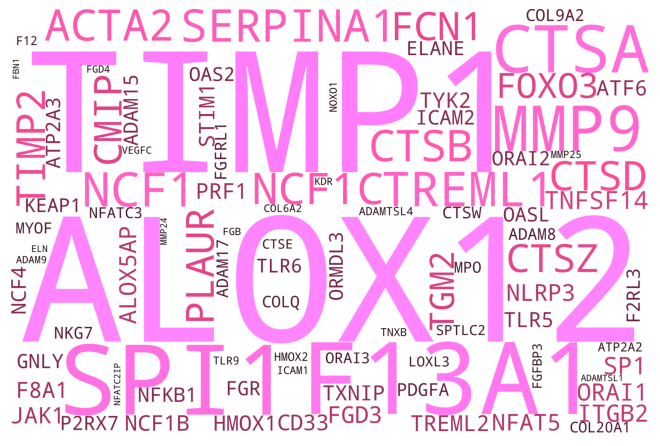

In [34]:
def tf_pink_func(df_grp):
    def pink_func(word=None, font_size=None, 
                       position=None, orientation=None, 
                       font_path=None, random_state=2):
        
        h = int(1000* df_grp[df_grp['name']==word]['log2fc'].values)
        s = int(300* df_grp[df_grp['name']==word]['log2fc'].values)
        l = int(600* df_grp[df_grp['name']==word]['log2fc'].values)

        ##orange (1000, 500, 200), (1000, 500, 400), (1000,300,600), (200, 50, 100)
        return "rgb({}%, {}%, {}%)".format(h, s ,l)#"rgb(0%%, 255%% * %d, 0%%)" % (360 * df_grp[df_grp['name']==word]['log2fc'])
    return pink_func


#Cluster_wordcloud(log2fc_link3, set(up_link_3), tf_pink_func, 'wc_cluster_link.pdf')#log2fc_link3

Cluster_wordcloud(df.logFC/5, df.index, tf_pink_func, 'wc_cluster_link.pdf')#log2fc_link3

> #### <u> <font color=red> Fig. S11b </font>  </u>

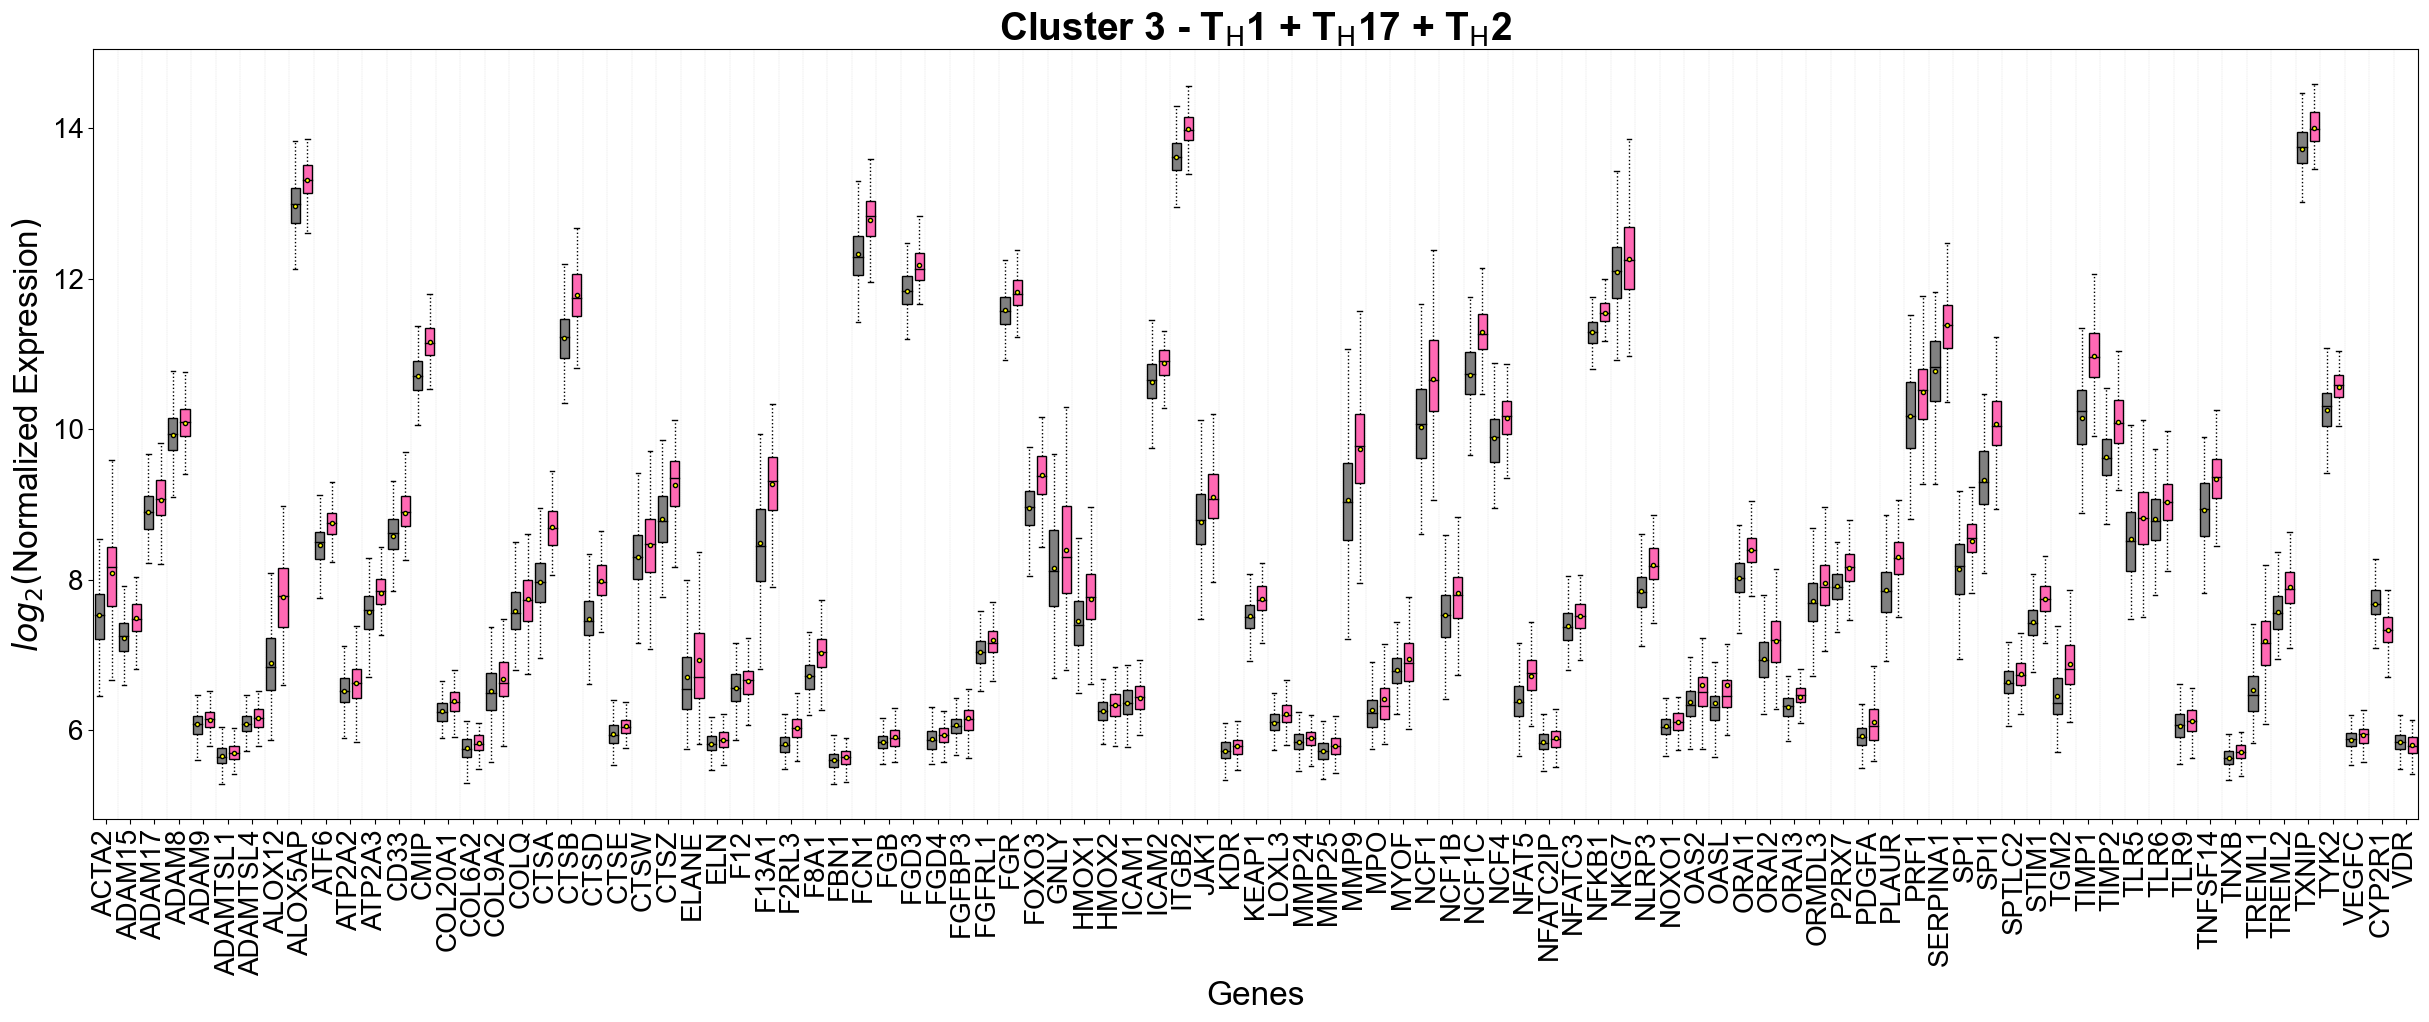

In [35]:
## add ['CYP2R1', 'VDR']
DE_Boxplot(2 , list(df.sort_index().index)+['CYP2R1', 'VDR'], 'hotpink', 'Cluster 3 - T$_\mathrm{H}$1 + T$_\mathrm{H}$17 + T$_\mathrm{H}$2', 'Wound_DE_Cluster3_Th1.pdf', [30,10], 20, 1.2)